## Sentiment Analysis in Python

#### This notebook was created using https://www.youtube.com/watch?v=QpzMWQvxXWk&t=157s as an example. Here, we will be using 2 different techniques and we'll compare the results:
- 'Bag of words' approach using VADER (Valence Aware Dictionary and sEntiment Reasoner)
- Roberta Pretrained Model from Huggingface

I added several improvements in addition to the code presented in the video, for example:

- Instead of loading the provided csv file, I imported sqlite database using sqlite3 module and loaded it to a DF
- Note that database.sqlite file was too large to be imported into github; it can be downloaded from: https://www.kaggle.com/code/robikscube/sentiment-analysis-python-youtube-tutorial/data?select=database.sqlite
- Added annotations to the barplot (Figure 1)
----------------------------------------------------------------------------------------------------------------------------------------------

#### Steps:

1. Step 0. Read in Data and NLTK Basics
2. Step 1. VADER Seniment Scoring
3. Step 3. Roberta Pretrained Model
4. Step 3. Combine and compare
5. Step 4: Review Examples:
6. Extra: The Transformers Pipeline

#### Step 0. Read in Data and NLTK Basics

In [207]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

# pip install nltk
import nltk

In [208]:
# Import necessary module
# import sqlite3

# conn = sqlite3.connect("database.sqlite\\database.sqlite")

# # Query the sqlite_master table to get the names of all tables
# c = conn.cursor()
# c.execute("SELECT name FROM sqlite_master WHERE type='table';")
# table_names = c.fetchall()

# print(table_names)

# Query the database and load the result into a Pandas DataFrame
# df = pd.read_sql_query("SELECT * FROM Reviews", conn)

# Close the database connection
# conn.close()

# df.head()

# df.shape

#### There were over a half a million reviews in the original db (that had over 300 MB) so in order to be able to upload the file to Github I am scaling down this dataset for reducing the analysis time.

### Scaling down to 5000 results and saving to database_smaller.sqlite

In [234]:
# df = df.head(5000)
# df.shape
# Save the smaller database as 'database_smaller.sqlite' in the same folder
# smaller_conn = sqlite3.connect("database.sqlite\\database_smaller.sqlite")
# df.to_sql("Reviews", smaller_conn, if_exists="replace", index=False)
# smaller_conn.close()

In [ ]:
# Import necessary module
import sqlite3

conn = sqlite3.connect("database.sqlite\\database_smaller.sqlite")

# Query the sqlite_master table to get the names of all tables
c = conn.cursor()
c.execute("SELECT name FROM sqlite_master WHERE type='table';")
table_names = c.fetchall()

# Query the database and load the result into a Pandas DataFrame
df = pd.read_sql_query("SELECT * FROM Reviews", conn)
conn.close()

#### Ok, now we have 1000 revies in the dataset. 

#### Let's conduct a quick EDA to explore the dataset a bit
Let's start with plotting the grouped star reviews from score variable

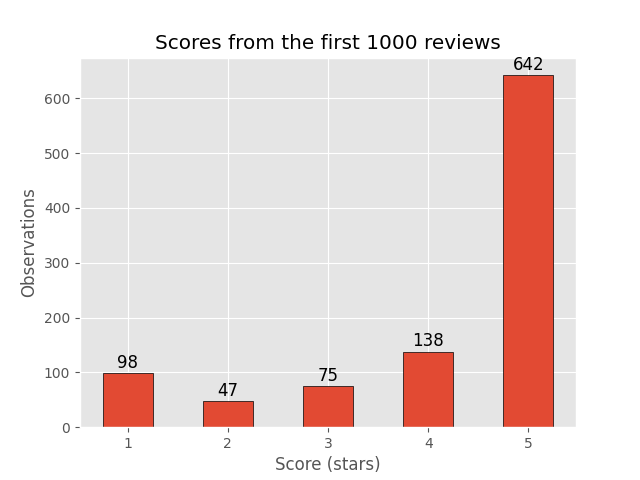

In [215]:
%matplotlib widget

fig, ax = plt.subplots()

freq = df['Score'].value_counts().sort_values()

ax.bar(freq.index, freq.values,
        width=0.5,
        edgecolor='black')

ax.set_xlabel('Score (stars)')
ax.set_ylabel('Observations')
ax.set_title('Scores from the first 1000 reviews')

# Adding annotations to the plot
for x, y in zip(freq.index, freq.values):
    ax.annotate(str(int(y)), xy=(x, y+10), ha='center', fontsize=12)

plt.show()

## NLPK basics. We introduce the NLPK package to analyze the words

In [216]:
# Basic example
example = df['Text'][50]
print(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


In [217]:
# We need to download the packages below in order to use the word_tokenize, pos_tag and other nltk functions.

import nltk.data
nltk.download('punkt') # Enables word_tokenize. Found with help of https://www.youtube.com/watch?v=GPeWi_2JL_c
nltk.download('averaged_perceptron_tagger') # Enables pos_tag.
nltk.download('maxent_ne_chunker') #Enables chunk.ne_chunk
nltk.download('words') #Enables chunk.ne_chunk

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\macko\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\macko\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\macko\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\macko\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [218]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['This', 'oatmeal', 'is', 'not', 'good', '.', 'Its', 'mushy', ',', 'soft']

In [219]:
# tagging tokens with part-of-speech categories
tagged = nltk.pos_tag(tokens)

In [220]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint() # pretty-print

(S
  This/DT
  oatmeal/NN
  is/VBZ
  not/RB
  good/JJ
  ./.
  Its/PRP$
  mushy/NN
  ,/,
  soft/JJ
  ,/,
  I/PRP
  do/VBP
  n't/RB
  like/VB
  it/PRP
  ./.
  (ORGANIZATION Quaker/NNP Oats/NNPS)
  is/VBZ
  the/DT
  way/NN
  to/TO
  go/VB
  ./.)


### Step 1. VADER Seniment Scoring

- VADER uses a "bag of words" approach. 
- It does not score combination of words but each word separately to average to a total score 
- SentimentIntensityAnalyzer will be used to get neg/neu/pos scores
- Stop words are removed ('and', 'the', etc...)

In [221]:
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon') # Enables SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\macko\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [222]:
sia = SentimentIntensityAnalyzer()
sia.polarity_scores('I am very happy')  # Example sentence to see the scores

{'neg': 0.0, 'neu': 0.334, 'pos': 0.666, 'compound': 0.6115}

In [223]:
sia.polarity_scores('I hate it')

{'neg': 0.787, 'neu': 0.213, 'pos': 0.0, 'compound': -0.5719}

In [224]:
sia.polarity_scores(example)

{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

Now we know how to use nltk. We now have to run this on the entire dataset. 

In [225]:
# Run polarity evaluation on the entire dataset
# tqdm is a Python library that provides a progress bar for iterators in console-based applications.

from tqdm import tqdm
%matplotlib widget

results = {}

for i, row in tqdm(df.iterrows(), total=len(df), desc='Processing rows'):
    text = row['Text']
    myid = row['Id']
    results[myid] = sia.polarity_scores(text)

Processing rows: 100%|██████████| 1000/1000 [00:00<00:00, 2039.50it/s]


In [226]:
df_results = pd.DataFrame.from_dict(results)

In [227]:
df_results = df_results.T
df_results

,neg,neu,pos,compound
1,0.000,0.695,0.305,0.9441
2,0.138,0.862,0.000,-0.5664
3,0.091,0.754,0.155,0.8265
4,0.000,1.000,0.000,0.0000
5,0.000,0.552,0.448,0.9468
...,...,...,...,...
996,0.026,0.721,0.253,0.9788
997,0.000,0.786,0.214,0.9309
998,0.000,0.673,0.327,0.9634
999,0.063,0.874,0.062,-0.0129


In [228]:
df_results = df_results.reset_index().rename(columns={'index':'Id'})
df_results.head()

,Id,neg,neu,pos,compound
0,1,0.000,0.695,0.305,0.9441
1,2,0.138,0.862,0.000,-0.5664
2,3,0.091,0.754,0.155,0.8265
3,4,0.000,1.000,0.000,0.0000
4,5,0.000,0.552,0.448,0.9468


In [229]:
print(df.shape, df_results.shape)
print(df.columns, df_results.columns)

(1000, 10) (1000, 5)
Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object') Index(['Id', 'neg', 'neu', 'pos', 'compound'], dtype='object')


In [230]:
df_results = df_results.merge(df, how='left')
df_results.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


### Plotting 3 polarity scores (negative, neutral and positive) vs Star-score 

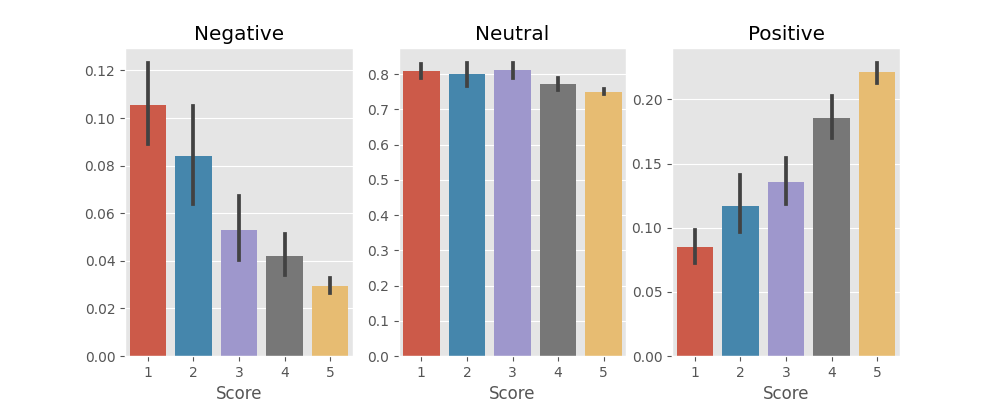

In [231]:
# Create a plot with 1 row and 2 columns that share the y axis label
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize = (10,4))

sns.barplot(x='Score', y='neg', data=df_results, ax=ax0)
sns.barplot(x='Score', y='neu', data=df_results, ax=ax1)
sns.barplot(x='Score', y='pos', data=df_results, ax=ax2)

ax0.set_title('Negative')
ax1.set_title('Neutral')
ax2.set_title('Positive')

ax0.set(ylabel=None)
ax1.set(ylabel=None)
ax2.set(ylabel=None)
plt.show()

### Plotting compound polarity score vs Star-score

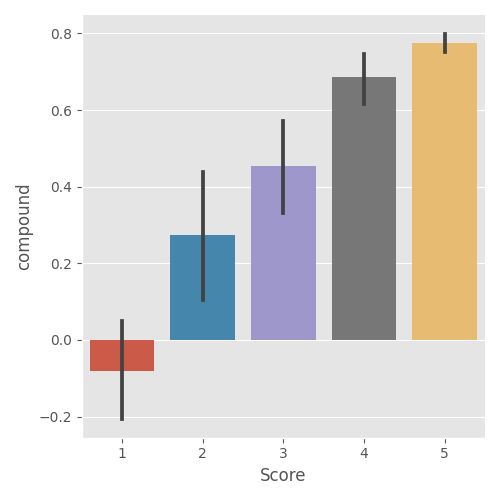

In [232]:
ax_compound = sns.catplot(x='Score', y='compound', data=df_results, kind='bar')
plt.show()